# 📰 NewsSumm Dataset - Exploratory Data Analysis

**Project:** Multi-Document Summarization for Indian News  
**Phase:** 1 - Data Ingestion & EDA  
**Date:** 2026-02-01  

---

## Table of Contents
1. [Setup & Dependencies](#1-setup--dependencies)
2. [Data Loading & Inspection](#2-data-loading--inspection)
3. [Column Standardization](#3-column-standardization)
4. [Data Cleaning](#4-data-cleaning)
5. [Statistical Analysis](#5-statistical-analysis)
6. [Visualizations](#6-visualizations)
7. [Summary & Next Steps](#7-summary--next-steps)

---
## 1. Setup & Dependencies

In [1]:
# Core libraries
import pandas as pd
import numpy as np
from pathlib import Path
import re
import warnings

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP utilities
from collections import Counter

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', None)

# Plotting style
plt.style.use('ggplot')
sns.set_palette('husl')

# Define paths
PROJECT_ROOT = Path.cwd().parent.parent
DATA_RAW = PROJECT_ROOT / 'data' / 'raw'
DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'

print(f"📁 Project Root: {PROJECT_ROOT}")
print(f"📂 Raw Data Path: {DATA_RAW}")
print("\n✅ All dependencies loaded successfully!")

📁 Project Root: C:\SF\newssumm_research
📂 Raw Data Path: C:\SF\newssumm_research\data\raw

✅ All dependencies loaded successfully!


---
## 2. Data Loading & Inspection

In [2]:
# Load the Excel file
DATASET_PATH = DATA_RAW / 'NewsSumm Dataset.xlsx'

print(f"📖 Loading dataset from: {DATASET_PATH}")
df_raw = pd.read_excel(DATASET_PATH)

print(f"\n✅ Dataset loaded successfully!")
print(f"   Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")

📖 Loading dataset from: C:\SF\newssumm_research\data\raw\NewsSumm Dataset.xlsx

✅ Dataset loaded successfully!
   Shape: 348,766 rows × 6 columns


In [3]:
# Inspect column names (crucial for standardization)
print("📋 Original Column Names:")
print("-" * 50)
for i, col in enumerate(df_raw.columns, 1):
    print(f"   {i}. '{col}' (dtype: {df_raw[col].dtype})")

📋 Original Column Names:
--------------------------------------------------
   1. 'newspaper_name' (dtype: str)
   2. 'published_date
' (dtype: object)
   3. 'headline' (dtype: object)
   4. 'article_text' (dtype: object)
   5. 'human_summary' (dtype: object)
   6. 'news_category' (dtype: object)


In [4]:
# Preview first few rows
print("👀 First 3 Rows Preview:")
df_raw.head(3)

👀 First 3 Rows Preview:


,newspaper_name,published_date\n,headline,article_text,human_summary,news_category
0,Indian Express,2020-06-01 00:00:00,Virus may be invisible enemy but COVID warriors invincible: PM Modi,Prime Minister Narendra Modi Monday hailed the contribution of medical workers during the coronavirus pandemic. Addressing an event at the Rajiv Gandhi Health University in Bengaluru via video con...,"Prime Minister of India said that the Virus may be an Invisible enemy. but our warriors, medical workers are invincible. He also stressed that violence against COVID warriors will not be tolerated.",National News
1,Economic Times,2013-02-11 00:00:00,"Economy can bounce back, says PM Modi","ALLAHABAD: At least 20 persons were killed, and scores of others injured on Sunday in a stampede at Allahabad railway station teeming with thousands of pilgrims returning after a holy dip at the M...","In Maha Kumbh, nearly 20 persons were killed. Senior Police officer said that 20 people died in the stampede that occurred at 7pm.\nUttar Pradesh government ordered an inquiry and asked the railwa...",National News
2,Business Standard,2013-02-11 00:00:00,At least 20 killed in stampede in Allahabad,"At least 20 people were killed, and scores of others injured tonight in a stampede at Allahabad railway station, teeming with thousands of pilgrims returning after a holy dip at the Maha Kumbh her...",As per the sources 20 people died and scores were injured in the mishap. The stampede occurred at 7 pm when platform no 5 and 6 were packed with thousands of passengers.\nA few people received min...,National News


In [5]:
# Check for missing values
print("🔍 Missing Values Analysis:")
print("-" * 50)
missing_stats = pd.DataFrame({
    'Column': df_raw.columns,
    'Missing Count': df_raw.isnull().sum().values,
    'Missing %': (df_raw.isnull().sum().values / len(df_raw) * 100).round(2)
})
print(missing_stats.to_string(index=False))

🔍 Missing Values Analysis:
--------------------------------------------------
          Column  Missing Count  Missing %
  newspaper_name              4       0.00
published_date\n              4       0.00
        headline              5       0.00
    article_text             27       0.01
   human_summary            240       0.07
   news_category              6       0.00


In [6]:
# Data types and memory usage
print("💾 Dataset Info:")
print("-" * 50)
df_raw.info(memory_usage='deep')

💾 Dataset Info:
--------------------------------------------------
<class 'pandas.DataFrame'>
RangeIndex: 348766 entries, 0 to 348765
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   newspaper_name   348762 non-null  str   
 1   published_date
  348762 non-null  object
 2   headline         348761 non-null  object
 3   article_text     348739 non-null  object
 4   human_summary    348526 non-null  object
 5   news_category    348760 non-null  object
dtypes: object(5), str(1)
memory usage: 1.5 GB


---
## 3. Column Standardization

Based on the inspection, we need to:
1. Clean column names (remove whitespace, special characters)
2. Map to standardized names for our pipeline

In [7]:
# Create a working copy
df = df_raw.copy()

# Step 1: Clean column names (strip whitespace and newlines)
df.columns = df.columns.str.strip().str.replace('\n', '', regex=False)

print("📋 Cleaned Column Names:")
for col in df.columns:
    print(f"   - '{col}'")

📋 Cleaned Column Names:
   - 'newspaper_name'
   - 'published_date'
   - 'headline'
   - 'article_text'
   - 'human_summary'
   - 'news_category'


In [8]:
# Step 2: Define column mapping based on semantic meaning
# This mapping standardizes column names for the rest of the pipeline

COLUMN_MAPPING = {
    'newspaper_name': 'source',
    'published_date': 'date',
    'headline': 'headline',
    'article_text': 'articles',      # Main article content
    'human_summary': 'summary',       # Target summary
    'news_category': 'category'       # Can serve as cluster grouping
}

# Apply mapping (only for columns that exist)
existing_mapping = {k: v for k, v in COLUMN_MAPPING.items() if k in df.columns}
df = df.rename(columns=existing_mapping)

print("✅ Standardized Column Mapping:")
print("-" * 50)
for old, new in existing_mapping.items():
    print(f"   '{old}' → '{new}'")

print("\n📋 Final Columns:")
print(df.columns.tolist())

✅ Standardized Column Mapping:
--------------------------------------------------
   'newspaper_name' → 'source'
   'published_date' → 'date'
   'headline' → 'headline'
   'article_text' → 'articles'
   'human_summary' → 'summary'
   'news_category' → 'category'

📋 Final Columns:
['source', 'date', 'headline', 'articles', 'summary', 'category']


In [9]:
# Verify the standardization
print("👀 Standardized DataFrame Preview:")
df.head(2)

👀 Standardized DataFrame Preview:


,source,date,headline,articles,summary,category
0,Indian Express,2020-06-01 00:00:00,Virus may be invisible enemy but COVID warriors invincible: PM Modi,Prime Minister Narendra Modi Monday hailed the contribution of medical workers during the coronavirus pandemic. Addressing an event at the Rajiv Gandhi Health University in Bengaluru via video con...,"Prime Minister of India said that the Virus may be an Invisible enemy. but our warriors, medical workers are invincible. He also stressed that violence against COVID warriors will not be tolerated.",National News
1,Economic Times,2013-02-11 00:00:00,"Economy can bounce back, says PM Modi","ALLAHABAD: At least 20 persons were killed, and scores of others injured on Sunday in a stampede at Allahabad railway station teeming with thousands of pilgrims returning after a holy dip at the M...","In Maha Kumbh, nearly 20 persons were killed. Senior Police officer said that 20 people died in the stampede that occurred at 7pm.\nUttar Pradesh government ordered an inquiry and asked the railwa...",National News


---
## 4. Data Cleaning

Key cleaning operations:
1. Strip HTML tags from article text
2. Remove extra whitespace
3. Handle special characters

In [10]:
def clean_html_tags(text):
    """Remove HTML tags from text.
    
    Args:
        text: Input string potentially containing HTML
        
    Returns:
        Cleaned string with HTML tags removed
    """
    if pd.isna(text):
        return text
    
    # Convert to string if needed
    text = str(text)
    
    # Remove HTML tags
    clean = re.sub(r'<[^>]+>', '', text)
    
    # Remove HTML entities
    clean = re.sub(r'&[a-zA-Z]+;', ' ', clean)
    clean = re.sub(r'&#[0-9]+;', ' ', clean)
    
    # Normalize whitespace
    clean = re.sub(r'\s+', ' ', clean).strip()
    
    return clean


def clean_text(text):
    """Comprehensive text cleaning function.
    
    Args:
        text: Input string
        
    Returns:
        Cleaned and normalized string
    """
    if pd.isna(text):
        return text
    
    text = str(text)
    
    # Remove HTML
    text = clean_html_tags(text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


print("✅ Cleaning functions defined!")

✅ Cleaning functions defined!


In [11]:
# Test cleaning function with a sample
sample_text = df['articles'].iloc[0] if 'articles' in df.columns else "No articles column found"
print("🧪 Testing cleaning function:")
print("-" * 50)
print(f"Original (first 500 chars):\n{str(sample_text)[:500]}...")
print(f"\nCleaned (first 500 chars):\n{clean_text(sample_text)[:500]}...")

🧪 Testing cleaning function:
--------------------------------------------------
Original (first 500 chars):
Prime Minister Narendra Modi Monday hailed the contribution of medical workers during the coronavirus pandemic. Addressing an event at the Rajiv Gandhi Health University in Bengaluru via video conference, Modi said, “The virus may be an invisible enemy. But our warriors, medical workers are invincible. In the battle of Invisible vs Invincible, our medical workers are sure to win.” He also said that the world is looking at them with gratitude, hope, and seeks both ‘care’ and ‘cure’.

“At the root...

Cleaned (first 500 chars):
Prime Minister Narendra Modi Monday hailed the contribution of medical workers during the coronavirus pandemic. Addressing an event at the Rajiv Gandhi Health University in Bengaluru via video conference, Modi said, “The virus may be an invisible enemy. But our warriors, medical workers are invincible. In the battle of Invisible vs Invincible, our medical wo

In [12]:
# Apply cleaning to text columns
print("🧹 Applying text cleaning...")

text_columns = ['articles', 'summary', 'headline']

for col in text_columns:
    if col in df.columns:
        df[f'{col}_clean'] = df[col].apply(clean_text)
        print(f"   ✓ Created '{col}_clean' column")

print("\n✅ Cleaning complete!")

🧹 Applying text cleaning...
   ✓ Created 'articles_clean' column
   ✓ Created 'summary_clean' column
   ✓ Created 'headline_clean' column

✅ Cleaning complete!


---
## 5. Statistical Analysis

In [13]:
def count_tokens(text, method='whitespace'):
    """Count tokens in text.
    
    Args:
        text: Input string
        method: 'whitespace' for simple split, 'words' for word-only count
        
    Returns:
        Token count
    """
    if pd.isna(text) or text == '':
        return 0
    
    text = str(text)
    
    if method == 'whitespace':
        return len(text.split())
    else:
        return len(re.findall(r'\b\w+\b', text))


# Calculate token counts
print("📊 Calculating token statistics...")

if 'articles_clean' in df.columns:
    df['article_token_count'] = df['articles_clean'].apply(count_tokens)
    
if 'summary_clean' in df.columns:
    df['summary_token_count'] = df['summary_clean'].apply(count_tokens)

print("✅ Token counts calculated!")

📊 Calculating token statistics...
✅ Token counts calculated!


In [14]:
# Token Statistics Summary
print("📈 TOKEN STATISTICS SUMMARY")
print("=" * 60)

if 'article_token_count' in df.columns:
    print("\n📰 ARTICLE STATISTICS:")
    print(f"   • Total articles: {len(df):,}")
    print(f"   • Average tokens per article: {df['article_token_count'].mean():,.1f}")
    print(f"   • Median tokens per article: {df['article_token_count'].median():,.1f}")
    print(f"   • Min tokens: {df['article_token_count'].min():,}")
    print(f"   • Max tokens: {df['article_token_count'].max():,}")
    print(f"   • Std deviation: {df['article_token_count'].std():,.1f}")

if 'summary_token_count' in df.columns:
    print("\n📝 SUMMARY STATISTICS:")
    print(f"   • Average tokens per summary: {df['summary_token_count'].mean():,.1f}")
    print(f"   • Median tokens per summary: {df['summary_token_count'].median():,.1f}")
    print(f"   • Min tokens: {df['summary_token_count'].min():,}")
    print(f"   • Max tokens: {df['summary_token_count'].max():,}")
    print(f"   • Std deviation: {df['summary_token_count'].std():,.1f}")

if 'article_token_count' in df.columns and 'summary_token_count' in df.columns:
    compression_ratio = df['article_token_count'].mean() / df['summary_token_count'].mean()
    print("\n🔄 COMPRESSION RATIO:")
    print(f"   • Average compression: {compression_ratio:.2f}x")
    print(f"   • (Articles are ~{compression_ratio:.1f}x longer than summaries)")

📈 TOKEN STATISTICS SUMMARY

📰 ARTICLE STATISTICS:
   • Total articles: 348,766
   • Average tokens per article: 333.8
   • Median tokens per article: 273.0
   • Min tokens: 0
   • Max tokens: 5,295
   • Std deviation: 282.2

📝 SUMMARY STATISTICS:
   • Average tokens per summary: 94.6
   • Median tokens per summary: 92.0
   • Min tokens: 0
   • Max tokens: 4,807
   • Std deviation: 58.2

🔄 COMPRESSION RATIO:
   • Average compression: 3.53x
   • (Articles are ~3.5x longer than summaries)


In [15]:
# Category/Cluster Analysis
if 'category' in df.columns:
    print("\n📂 CATEGORY DISTRIBUTION:")
    print("=" * 60)
    
    category_stats = df['category'].value_counts()
    
    print(f"\n   • Total unique categories: {len(category_stats)}")
    print("\n   Top 10 Categories:")
    for cat, count in category_stats.head(10).items():
        pct = (count / len(df)) * 100
        print(f"      - {cat}: {count:,} ({pct:.1f}%)")


📂 CATEGORY DISTRIBUTION:

   • Total unique categories: 5491

   Top 10 Categories:
      - Politics: 48,797 (14.0%)
      - Business and Finance: 33,855 (9.7%)
      - National News: 33,012 (9.5%)
      - Local News: 29,853 (8.6%)
      - International News: 26,443 (7.6%)
      - Crime and Justice: 24,418 (7.0%)
      - Sports: 23,290 (6.7%)
      - Entertainment: 19,898 (5.7%)
      - Health and Wellness: 16,434 (4.7%)
      - Education: 13,710 (3.9%)


In [16]:
# Source/Newspaper Analysis
if 'source' in df.columns:
    print("\n📰 SOURCE (NEWSPAPER) DISTRIBUTION:")
    print("=" * 60)
    
    source_stats = df['source'].value_counts()
    
    print(f"\n   • Total unique sources: {len(source_stats)}")
    print("\n   Top 10 Sources:")
    for src, count in source_stats.head(10).items():
        pct = (count / len(df)) * 100
        print(f"      - {src}: {count:,} ({pct:.1f}%)")


📰 SOURCE (NEWSPAPER) DISTRIBUTION:

   • Total unique sources: 4532

   Top 10 Sources:
      - The Times of India: 33,247 (9.5%)
      - The Hindu: 30,275 (8.7%)
      - Hindustan Times: 24,868 (7.1%)
      - Indian Express: 18,365 (5.3%)
      - The Economic Times: 15,049 (4.3%)
      - The Tribune: 14,075 (4.0%)
      - The Pioneer: 10,610 (3.0%)
      - The Indian Express: 7,709 (2.2%)
      - Mint: 6,586 (1.9%)
      - The Asian Age: 5,946 (1.7%)


---
## 6. Visualizations

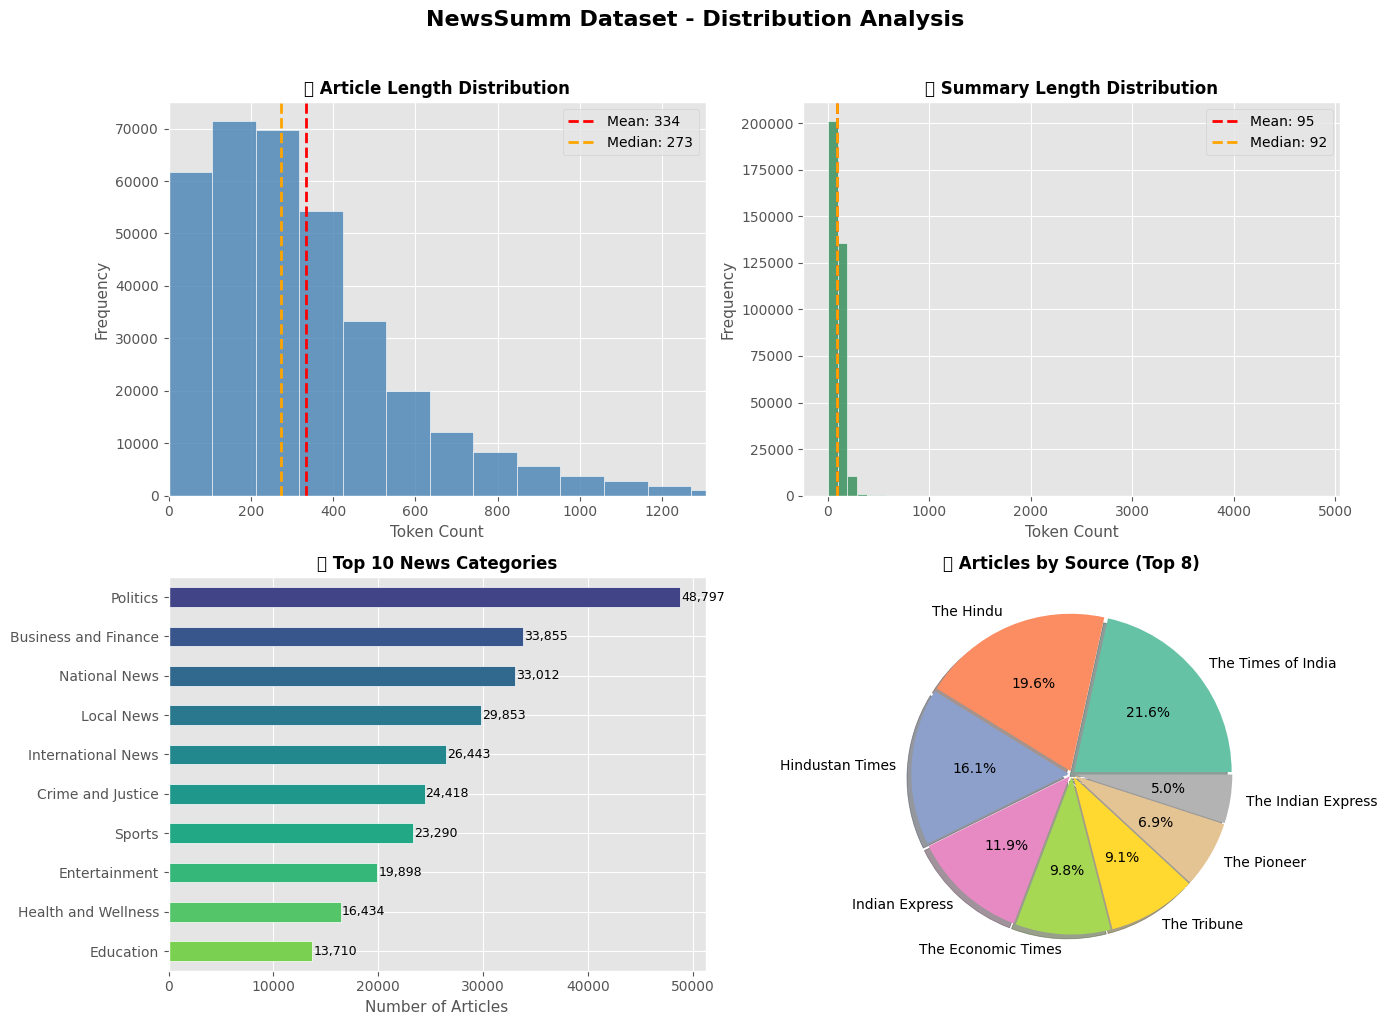


💾 Figure saved to: data/processed/eda_distributions.png


In [17]:
# Set up the figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('NewsSumm Dataset - Distribution Analysis', fontsize=16, fontweight='bold', y=1.02)

# Plot 1: Article Token Distribution
if 'article_token_count' in df.columns:
    ax1 = axes[0, 0]
    df['article_token_count'].hist(bins=50, ax=ax1, color='steelblue', edgecolor='white', alpha=0.8)
    ax1.axvline(df['article_token_count'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df['article_token_count'].mean():.0f}")
    ax1.axvline(df['article_token_count'].median(), color='orange', linestyle='--', linewidth=2, label=f"Median: {df['article_token_count'].median():.0f}")
    ax1.set_xlabel('Token Count', fontsize=11)
    ax1.set_ylabel('Frequency', fontsize=11)
    ax1.set_title('📰 Article Length Distribution', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.set_xlim(0, df['article_token_count'].quantile(0.99))  # Clip outliers for visibility

# Plot 2: Summary Token Distribution
if 'summary_token_count' in df.columns:
    ax2 = axes[0, 1]
    df['summary_token_count'].hist(bins=50, ax=ax2, color='seagreen', edgecolor='white', alpha=0.8)
    ax2.axvline(df['summary_token_count'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df['summary_token_count'].mean():.0f}")
    ax2.axvline(df['summary_token_count'].median(), color='orange', linestyle='--', linewidth=2, label=f"Median: {df['summary_token_count'].median():.0f}")
    ax2.set_xlabel('Token Count', fontsize=11)
    ax2.set_ylabel('Frequency', fontsize=11)
    ax2.set_title('📝 Summary Length Distribution', fontsize=12, fontweight='bold')
    ax2.legend()

# Plot 3: Category Distribution (Top 10)
if 'category' in df.columns:
    ax3 = axes[1, 0]
    category_counts = df['category'].value_counts().head(10)
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(category_counts)))
    category_counts.plot(kind='barh', ax=ax3, color=colors, edgecolor='white')
    ax3.set_xlabel('Number of Articles', fontsize=11)
    ax3.set_ylabel('')
    ax3.set_title('📂 Top 10 News Categories', fontsize=12, fontweight='bold')
    ax3.invert_yaxis()
    
    # Add value labels
    for i, (idx, val) in enumerate(category_counts.items()):
        ax3.text(val + 100, i, f'{val:,}', va='center', fontsize=9)

# Plot 4: Source Distribution (Top 8)
if 'source' in df.columns:
    ax4 = axes[1, 1]
    source_counts = df['source'].value_counts().head(8)
    colors = plt.cm.Set2(np.linspace(0, 1, len(source_counts)))
    wedges, texts, autotexts = ax4.pie(
        source_counts.values, 
        labels=source_counts.index,
        autopct='%1.1f%%',
        colors=colors,
        explode=[0.02] * len(source_counts),
        shadow=True
    )
    ax4.set_title('📰 Articles by Source (Top 8)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(DATA_PROCESSED / 'eda_distributions.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\n💾 Figure saved to: data/processed/eda_distributions.png")

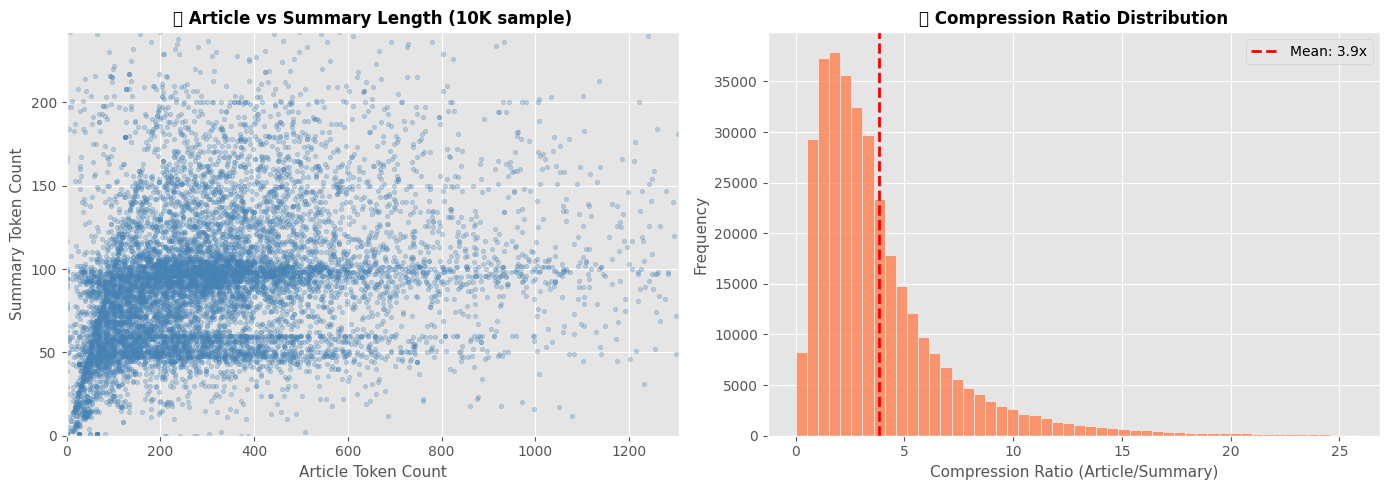


💾 Figure saved to: data/processed/eda_compression.png


In [18]:
# Compression Ratio Analysis
if 'article_token_count' in df.columns and 'summary_token_count' in df.columns:
    # Avoid division by zero
    df['compression_ratio'] = df.apply(
        lambda x: x['article_token_count'] / x['summary_token_count'] 
        if x['summary_token_count'] > 0 else np.nan, 
        axis=1
    )
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Sample data for scatter plot to avoid memory issues
    sample_size = min(10000, len(df))
    df_sample = df.sample(n=sample_size, random_state=42)
    
    # Scatter plot: Article vs Summary length
    ax1 = axes[0]
    ax1.scatter(
        df_sample['article_token_count'], 
        df_sample['summary_token_count'], 
        alpha=0.3, 
        s=10, 
        c='steelblue'
    )
    ax1.set_xlabel('Article Token Count', fontsize=11)
    ax1.set_ylabel('Summary Token Count', fontsize=11)
    ax1.set_title('📊 Article vs Summary Length (10K sample)', fontsize=12, fontweight='bold')
    ax1.set_xlim(0, df['article_token_count'].quantile(0.99))
    ax1.set_ylim(0, df['summary_token_count'].quantile(0.99))
    
    # Compression ratio distribution
    ax2 = axes[1]
    valid_ratios = df['compression_ratio'].dropna()
    valid_ratios = valid_ratios[valid_ratios < valid_ratios.quantile(0.99)]  # Remove outliers
    valid_ratios.hist(bins=50, ax=ax2, color='coral', edgecolor='white', alpha=0.8)
    ax2.axvline(valid_ratios.mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {valid_ratios.mean():.1f}x")
    ax2.set_xlabel('Compression Ratio (Article/Summary)', fontsize=11)
    ax2.set_ylabel('Frequency', fontsize=11)
    ax2.set_title('🔄 Compression Ratio Distribution', fontsize=12, fontweight='bold')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig(DATA_PROCESSED / 'eda_compression.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("\n💾 Figure saved to: data/processed/eda_compression.png")

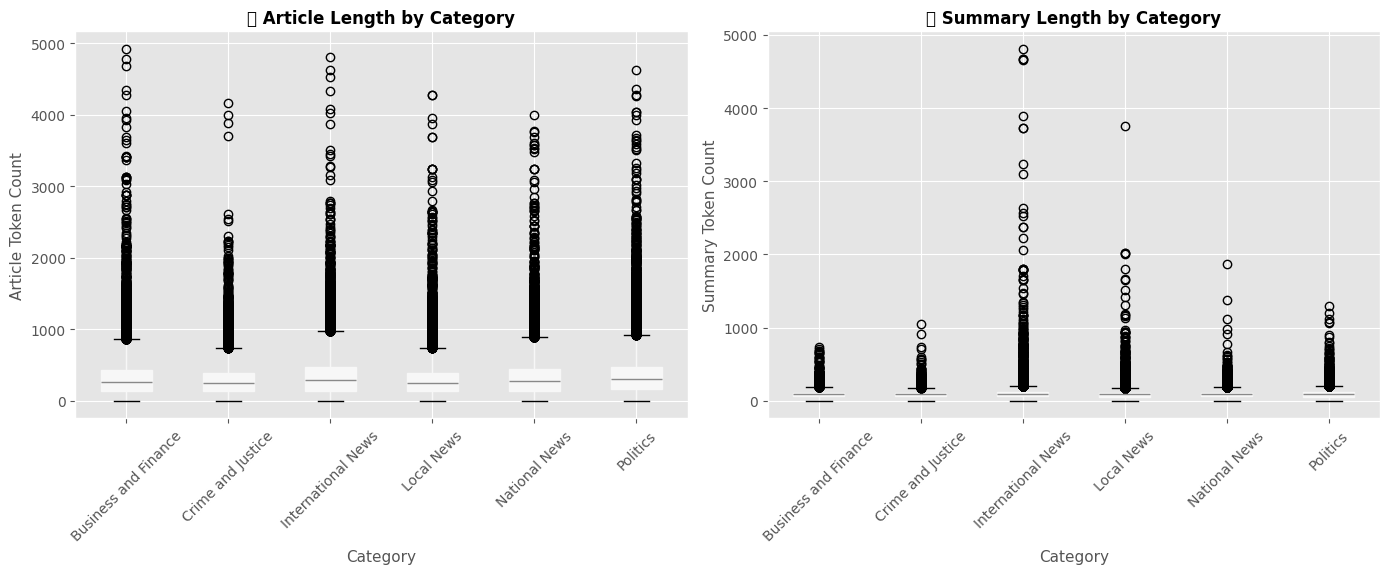


💾 Figure saved to: data/processed/eda_by_category.png


In [19]:
# Box plots by category (if categories exist)
if 'category' in df.columns and 'article_token_count' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    top_categories = df['category'].value_counts().head(6).index.tolist()
    df_top = df[df['category'].isin(top_categories)]
    
    # Article length by category
    ax1 = axes[0]
    df_top.boxplot(column='article_token_count', by='category', ax=ax1, patch_artist=True)
    ax1.set_xlabel('Category', fontsize=11)
    ax1.set_ylabel('Article Token Count', fontsize=11)
    ax1.set_title('📰 Article Length by Category', fontsize=12, fontweight='bold')
    plt.suptitle('')  # Remove auto-generated title
    ax1.tick_params(axis='x', rotation=45)
    
    # Summary length by category
    if 'summary_token_count' in df.columns:
        ax2 = axes[1]
        df_top.boxplot(column='summary_token_count', by='category', ax=ax2, patch_artist=True)
        ax2.set_xlabel('Category', fontsize=11)
        ax2.set_ylabel('Summary Token Count', fontsize=11)
        ax2.set_title('📝 Summary Length by Category', fontsize=12, fontweight='bold')
        plt.suptitle('')
        ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(DATA_PROCESSED / 'eda_by_category.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("\n💾 Figure saved to: data/processed/eda_by_category.png")

---
## 7. Summary & Next Steps

In [20]:
# Final Dataset Summary
print("=" * 70)
print("                    📊 DATASET SUMMARY REPORT")
print("=" * 70)

print(f"\n📁 Dataset: NewsSumm Dataset")
print(f"   • Total Records: {len(df):,}")
print(f"   • Columns: {len(df.columns)}")

if 'article_token_count' in df.columns:
    print(f"\n📰 Articles:")
    print(f"   • Avg length: {df['article_token_count'].mean():,.0f} tokens")
    print(f"   • Range: {df['article_token_count'].min():,} - {df['article_token_count'].max():,} tokens")

if 'summary_token_count' in df.columns:
    print(f"\n📝 Summaries:")
    print(f"   • Avg length: {df['summary_token_count'].mean():,.0f} tokens")
    print(f"   • Range: {df['summary_token_count'].min():,} - {df['summary_token_count'].max():,} tokens")

if 'category' in df.columns:
    print(f"\n📂 Categories: {df['category'].nunique()} unique")

if 'source' in df.columns:
    print(f"📰 Sources: {df['source'].nunique()} newspapers")

print("\n" + "=" * 70)
print("                    ✅ EDA COMPLETE")
print("=" * 70)

                    📊 DATASET SUMMARY REPORT

📁 Dataset: NewsSumm Dataset
   • Total Records: 348,766
   • Columns: 12

📰 Articles:
   • Avg length: 334 tokens
   • Range: 0 - 5,295 tokens

📝 Summaries:
   • Avg length: 95 tokens
   • Range: 0 - 4,807 tokens

📂 Categories: 5491 unique
📰 Sources: 4532 newspapers

                    ✅ EDA COMPLETE


In [21]:
# Save processed dataframe for next phase
OUTPUT_PATH = DATA_PROCESSED / 'newssumm_cleaned.parquet'

# Select relevant columns for saving
columns_to_save = [
    col for col in ['source', 'headline', 'articles_clean', 'summary_clean', 
                    'category', 'article_token_count', 'summary_token_count', 'compression_ratio']
    if col in df.columns
]

# Create a copy with consistent types
df_save = df[columns_to_save].copy()

# Convert object columns to string to handle mixed types
for col in df_save.select_dtypes(include=['object']).columns:
    df_save[col] = df_save[col].astype(str)

df_save.to_parquet(OUTPUT_PATH, index=False)

print(f"💾 Cleaned dataset saved to: {OUTPUT_PATH}")
print(f"   • Columns saved: {columns_to_save}")
print(f"   • Records: {len(df):,}")

💾 Cleaned dataset saved to: C:\SF\newssumm_research\data\processed\newssumm_cleaned.parquet
   • Columns saved: ['source', 'headline', 'articles_clean', 'summary_clean', 'category', 'article_token_count', 'summary_token_count', 'compression_ratio']
   • Records: 348,766
